<h1> <u>Stroke prediction</u></h1>

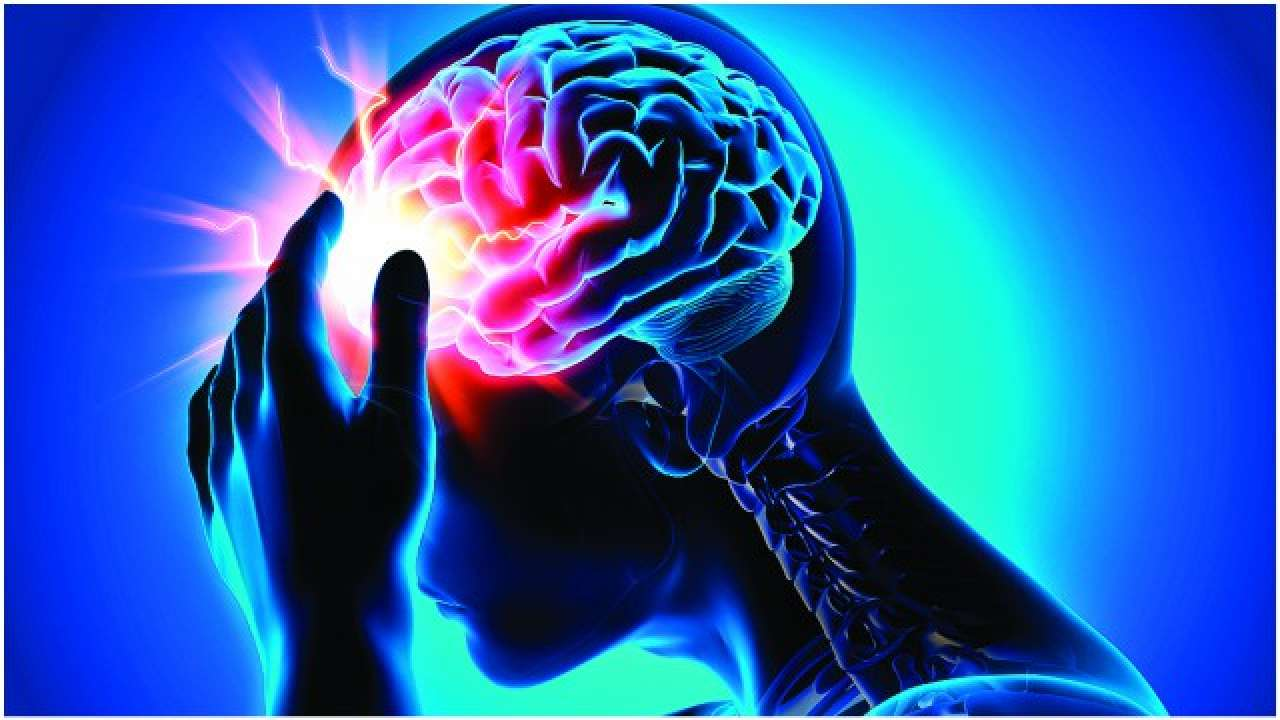

In [1]:
from IPython.display import Image
import urllib.request
url = "https://github.com/ashok49473/images/blob/main/brain-stroke.jpg?raw=true"
urllib.request.urlretrieve(url, "img.jpg")
Image(filename="img.jpg", width= 700, height=400)

# Problem statement
Stroke is sometimes termed as brain attack or a cardiovascular accident (CVA). It is much like a heart attack, only it occurs in the brain.<br>

It occurs when the supply of blood to the brain is reduced or blocked completely, which prevents brain tissue from getting oxygen and nutrients.<br>

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.<br>
Early identification of stroke can help doctors to give necessary medication to the patient.


## Machine Learning problem
Predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status.<br>
<b>Type</b> : Supervised Learning<br>
<b>Task</b> : Binary classification<br>
<b>Performance metric</b> : F1 score (since imbalanced classes)<br>

## About Dataset
Source : https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

### Attribute Information
<b>id</b>: unique identifier<br>
<b>gender</b>: Male, Female or Other<br>
<b>age</b>: age of the patient<br>
<b>hypertension</b>: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension<br>
<b>heart_disease</b>: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease<br>
<b>ever_married</b>: No or Yes<br>
<b>work_type</b>: children, Govt_jov, Never_worked, Private or Self-employed<br>
<b>Residence_type</b>: Rural or Urban<br>
<b>avg_glucose_level</b>: average glucose level in blood<br>
<b>bmi</b>: body mass index<br>
<b>smoking_status</b>: formerly smoked, never smoked, smokes or Unknown<br>
<b>stroke</b>: 1 if the patient had a stroke or 0 if not (target)<br>

# Libraries
Importing all the necessary python modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import pickle
import warnings
warnings.filterwarnings('ignore')

# settings
sns.set_style('whitegrid')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

### K-Fold Cross-Validation
Step 1: Randomly divide a dataset into k groups, or “folds”, of roughly equal size.<br>
Step 2: Choose one of the folds to be the holdout set. Fit the model on the remaining k-1 folds.<br>
Step 3: Calculate the test F1-score on the observations in the fold that was held out.<br>
Step 4: Repeat this process k times, using a different set each time as the holdout set.<br>
Step 5: Calculate the average of the k test F1-scores to get the overall test F1-score.

In [3]:
# Below function implements above steps.
def run_kfold(model, X_train, y_train, N_SPLITS = 10):
    f1_list = []
    oofs = np.zeros(len(X_train))
    folds = StratifiedKFold(n_splits=N_SPLITS)
    for i, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        
        print(f'\n------------- Fold {i + 1} -------------')
        X_trn, y_trn = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        model.fit(X_trn, y_trn)
        # Instead of directly predicting the classes we will obtain the probability of positive class.
        preds_val = model.predict_proba(X_val)[:,1]
        
        fold_f1 = f1_score(y_val, preds_val.round())
        f1_list.append(fold_f1)
        
        print(f'\nf1 score for validation set is {fold_f1}') 
        
        oofs[val_idx] = preds_val
        
    mean_f1 = sum(f1_list)/N_SPLITS
    print("\nMean validation f1 score :", mean_f1)
    
    oofs_score = f1_score(y_train, oofs.round())
    print(f'\nF1 score for oofs is {oofs_score}')
    return oofs

# Data preprocessing

In [4]:
# Load data into memory
data = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

print("No of columns in the data : ", len(data.columns))
print("No of rows in the data : ", len(data))

No of columns in the data :  12
No of rows in the data :  5110


In [5]:
# random sample of data
data.sample(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1375,14241,Male,17.000,0,0,No,Private,Urban,85.070,21.100,never smoked,0
191,66071,Male,51.000,1,0,Yes,Private,Urban,112.160,42.500,formerly smoked,1
3187,68408,Male,24.000,0,0,No,Private,Urban,88.380,20.100,smokes,0
4004,54240,Female,30.000,0,0,Yes,Govt_job,Urban,61.290,24.000,Unknown,0
4689,6924,Female,32.000,0,0,Yes,Private,Rural,102.870,26.600,smokes,0


In [6]:
# statistical summary of the data
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000,5110.000,5110.000,5110.000,5110.000,4909.000,5110.000
mean,36517.829,43.227,0.097,0.054,106.148,28.893,0.049
std,21161.722,22.613,0.297,0.226,45.284,7.854,0.215
min,67.000,0.080,0.000,0.000,55.120,10.300,0.000
25%,17741.250,25.000,0.000,0.000,77.245,23.500,0.000
50%,36932.000,45.000,0.000,0.000,91.885,28.100,0.000
75%,54682.000,61.000,0.000,0.000,114.090,33.100,0.000
max,72940.000,82.000,1.000,1.000,271.740,97.600,1.000


In [7]:
# null values
data.isna().sum().to_frame(name="Null count")

,Null count
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


## Variable separation

In [8]:
# features
features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married','work_type','Residence_type',
            'avg_glucose_level', 'bmi','smoking_status']

#target
target = 'stroke'

numerical_features = ['age', 'avg_glucose_level', 'bmi']

categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 
                        'Residence_type', 'smoking_status']

In [9]:
# Converting features into required datatypes
data[numerical_features] = data[numerical_features].astype(np.float64)

data[categorical_features] = data[categorical_features].astype('category')

# Replace Other label in gender with Female
data.gender.replace({'Other':"Female"}, inplace=True)

# Remove id column
data.drop('id', axis=1, inplace=True)

In [10]:
# data types
data[features+[target]].dtypes.to_frame(name="Data type")

,Data type
gender,object
age,float64
hypertension,category
heart_disease,category
ever_married,category
work_type,category
Residence_type,category
avg_glucose_level,float64
bmi,float64
smoking_status,category


## Train Test Split
- Dividing the total dataset into training and testing sets
- For Training 75% of data
- For Testing 25% of data

In [11]:
train, test = train_test_split(data, random_state=1, test_size=0.25, stratify=data.stroke)

print("No. of data points in training set : ", len(train))
print("No. of data points in testing set : ", len(test))

No. of data points in training set :  3832
No. of data points in testing set :  1278


## Fill Missing values
Using K-nearest neighbors imputation to fill missing values

In [12]:
imputer = KNNImputer(n_neighbors = 5)

train[numerical_features] = imputer.fit_transform(train[numerical_features])
test[numerical_features] = imputer.transform(test[numerical_features])

# Exploratory Data Analysis
Exploratory data analysis (EDA) is used to analyze and investigate data sets and summarize their main characteristics, often employing data visualization methods.

Performing EDA on Training set only (best practice to avoid overfitting)
## Univariate analysis
- Univariate analysis refers to the analysis of one variable.
- The purpose of univariate analysis is to understand the distribution of values for a single variable.

### A. Target distribution

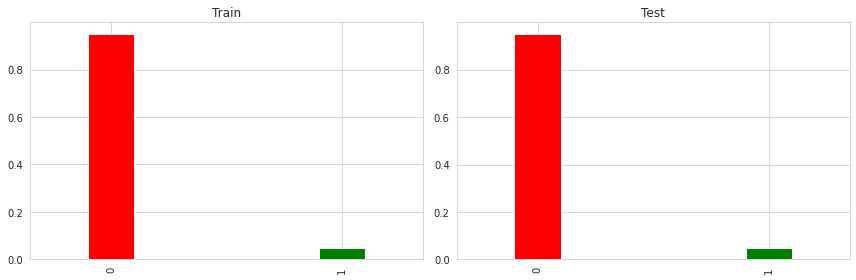

In [13]:
fig, axes = plt.subplots(ncols=2,figsize=(12, 4))
train[target].value_counts(normalize=True).plot.bar(width=0.2, color=('red','green'), ax=axes[0], title="Train")
test[target].value_counts(normalize=True).plot.bar(width=0.2, color=('red','green'), ax=axes[1], title="Test")
plt.tight_layout()
plt.show()

### B. Histogram

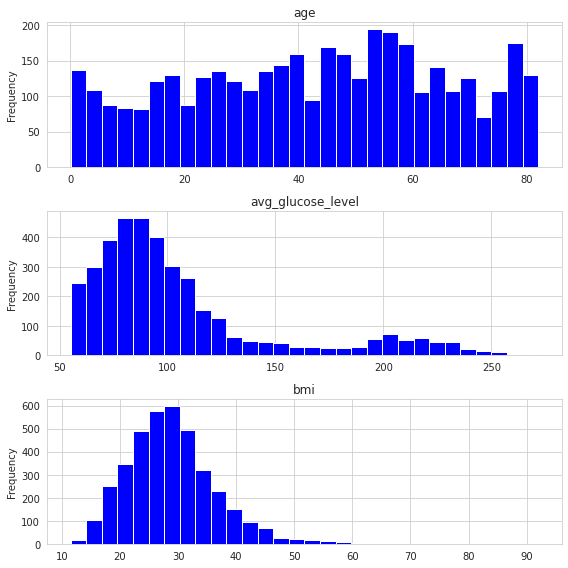

In [14]:
fig, axes = plt.subplots(nrows=3,figsize=(8, 8))

for i, c in enumerate(numerical_features):
    hist = train[c].plot(kind = 'hist', ax=axes[i], title=c, color='blue', bins=30)
    
plt.tight_layout()
plt.show()

### Boxplot (Outliers)
An outlier is a data point that differs significantly from other observations.

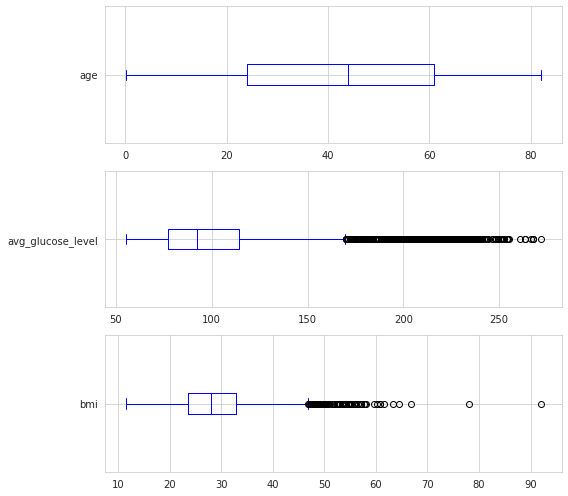

In [15]:
fig, axes = plt.subplots(nrows=3, figsize=(8, 7))

for i, c in enumerate(numerical_features):
    box = train[c].plot(kind = 'box', ax=axes[i], vert=False, color='blue')
    
plt.tight_layout()
plt.show()

### KDE Plot

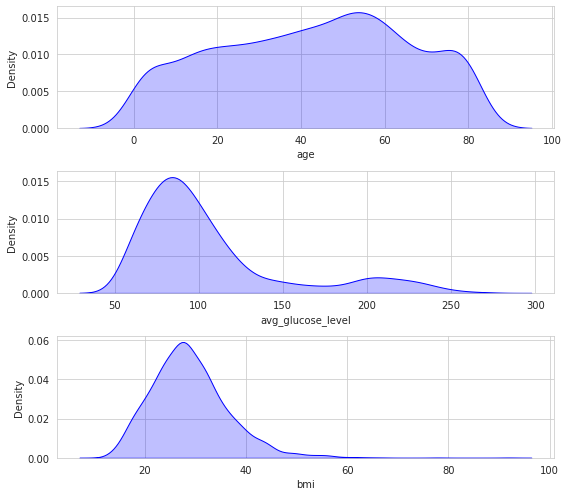

In [16]:
fig, axes = plt.subplots(nrows=3, figsize=(8, 7))

for i, c in enumerate(numerical_features):
    plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True, color='blue')
    
plt.tight_layout()
plt.show()

### Pie-Charts
Percentage of labels in categorical features

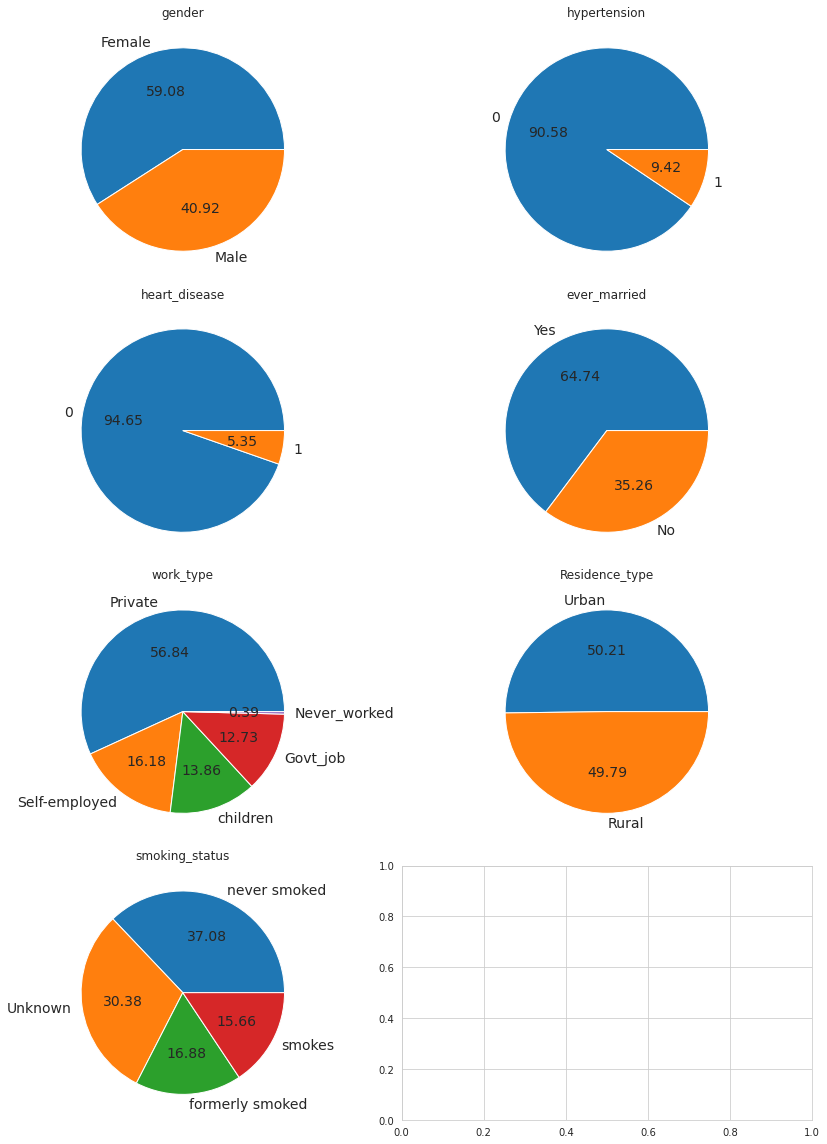

In [17]:
fig, axes = plt.subplots(4, 2, figsize=(12,16))
axes = [ax for axes_row in axes for ax in axes_row]

for i,c in enumerate(categorical_features):
    train[c].value_counts().plot(kind='pie', ax=axes[i], title=c, autopct="%.2f", fontsize=14)
    axes[i].set_ylabel('')
plt.tight_layout()
plt.show()

#  Bivariate analysis
It involves the analysis of two variables, for the purpose of determining the empirical relationship between them.

We perform bivariate analysis of features with respect to target.

### Box plots

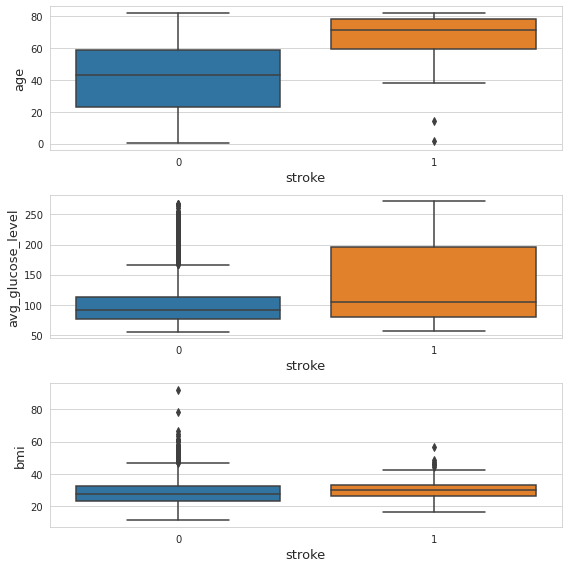

In [18]:
fig, axes = plt.subplots(nrows=3, figsize=(8, 8))
for i, c in enumerate(numerical_features): 
    plot = sns.boxplot(x=train[target], y=train[c], ax=axes[i])
    axes[i].set_ylabel(c, fontsize=13)
    axes[i].set_xlabel(target, fontsize=13)
plt.tight_layout()
plt.show()

### Target vs Mean of Numerical features

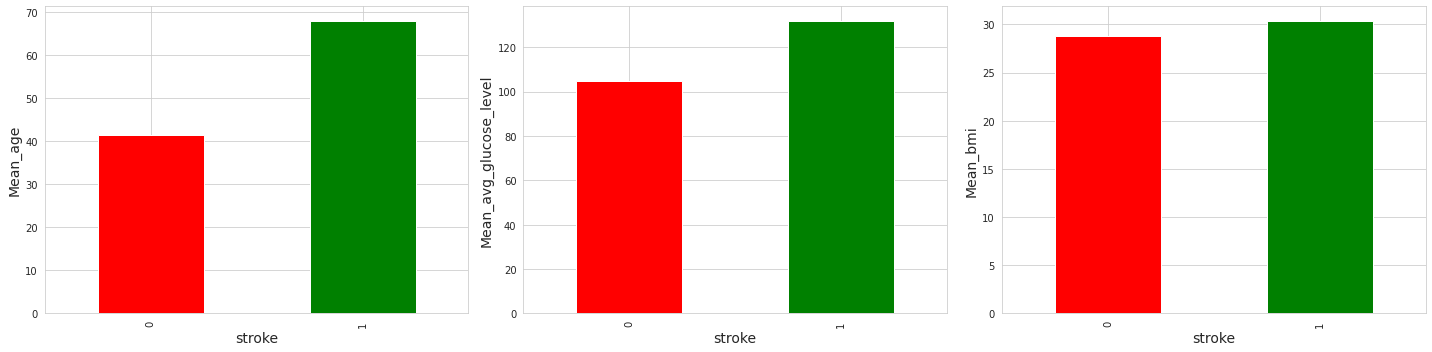

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
for i, c in enumerate(numerical_features):
    train.groupby(target)[c].mean().plot(kind = 'bar', ax=axes[i], color=('red','green'))
    axes[i].set_ylabel(f'Mean_{c}', fontsize=14)
    axes[i].set_xlabel('stroke', fontsize=14)
plt.tight_layout()

### Target vs categorical features

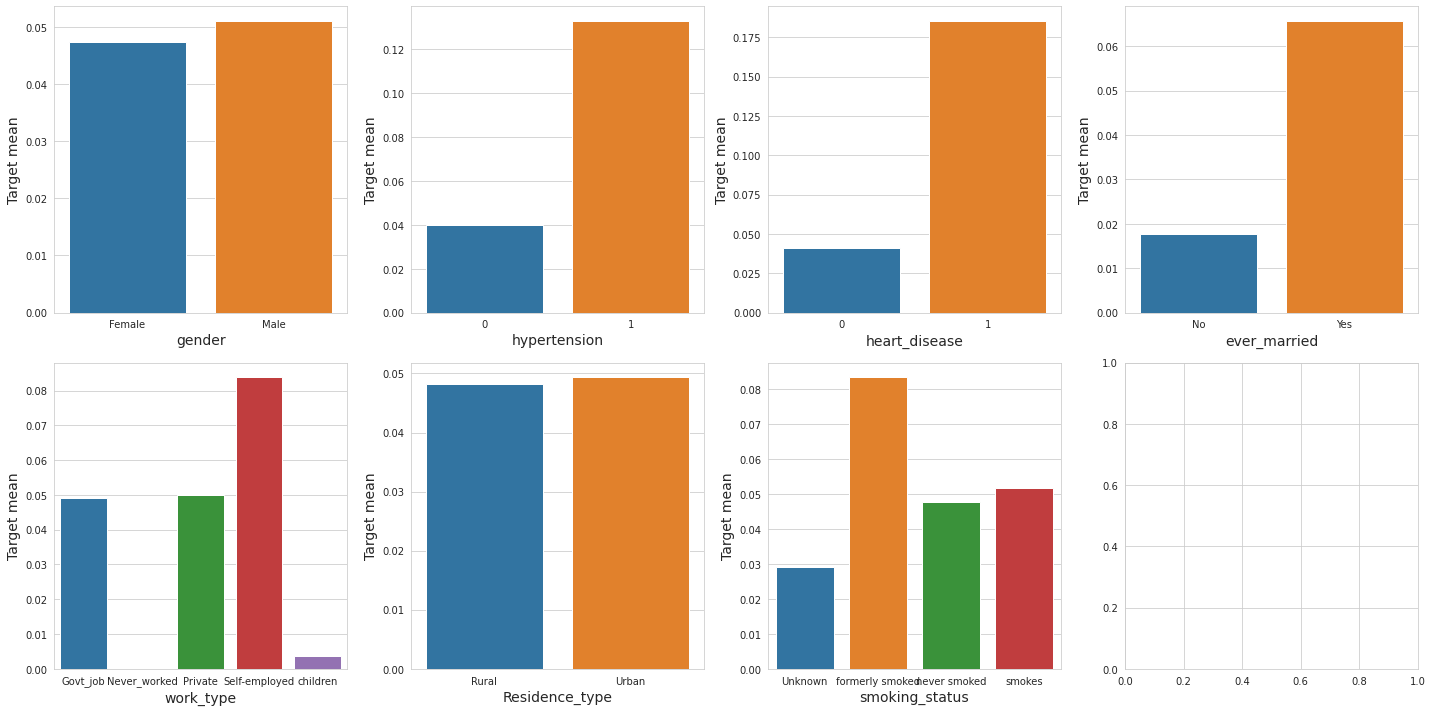

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(20,10))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(categorical_features):
    df = train[[c,target]].groupby(c).mean().reset_index()
    sns.barplot(df[c], df[target], ax=axes[i])
    axes[i].set_ylabel('Target mean', fontsize=14)
    axes[i].set_xlabel(c, fontsize=14)
    
plt.tight_layout()
plt.show()

# Feature Engineering
Feature engineering is the process of using domain knowledge to extract features from raw data. These features can be used to improve the performance of machine learning algorithms.

## New Features with Discretization
Discretization is the process of replacing the continuous values with a finite set of values

In [21]:
def age_group(x):
    if x<13: return "Child"
    elif 13<x<20: return "Teenager"
    elif 20<x<=60: return "Adult"
    else: return "Elder"
    
train["age_group"] = train.age.apply(age_group)
test['age_group'] = test.age.apply(age_group)

def bmi_group(x):
    if x<18.5 : return "UnderWeight"
    elif 18.5<x<25: return "Healthy"
    elif 25<x<30: return "OverWeight"
    else: return "Obese"

train["bmi_group"] = train.bmi.apply(age_group)
test['bmi_group'] = test.bmi.apply(age_group)

## OneHot encoding
- Replaces categorical column(s) with the binary value for each category.

In [22]:
# add new features
categorical_features.extend(["bmi_group", "age_group"])

encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(train[categorical_features])

cols = encoder.get_feature_names(categorical_features)

train.loc[:, cols] = encoder.transform(train[categorical_features])
test.loc[:, cols] = encoder.transform(test[categorical_features])

# Drop categorical features
train.drop(categorical_features, axis=1, inplace=True)
test.drop(categorical_features, axis=1, inplace=True)

## Feature Scaling
Standardize the numerical features

In [23]:
scaler = StandardScaler()
scaler.fit(train[numerical_features])

train.loc[:, numerical_features] = scaler.transform(train[numerical_features])
test.loc[:, numerical_features] = scaler.transform(test[numerical_features])

 ## Correlation
 Relationship between features

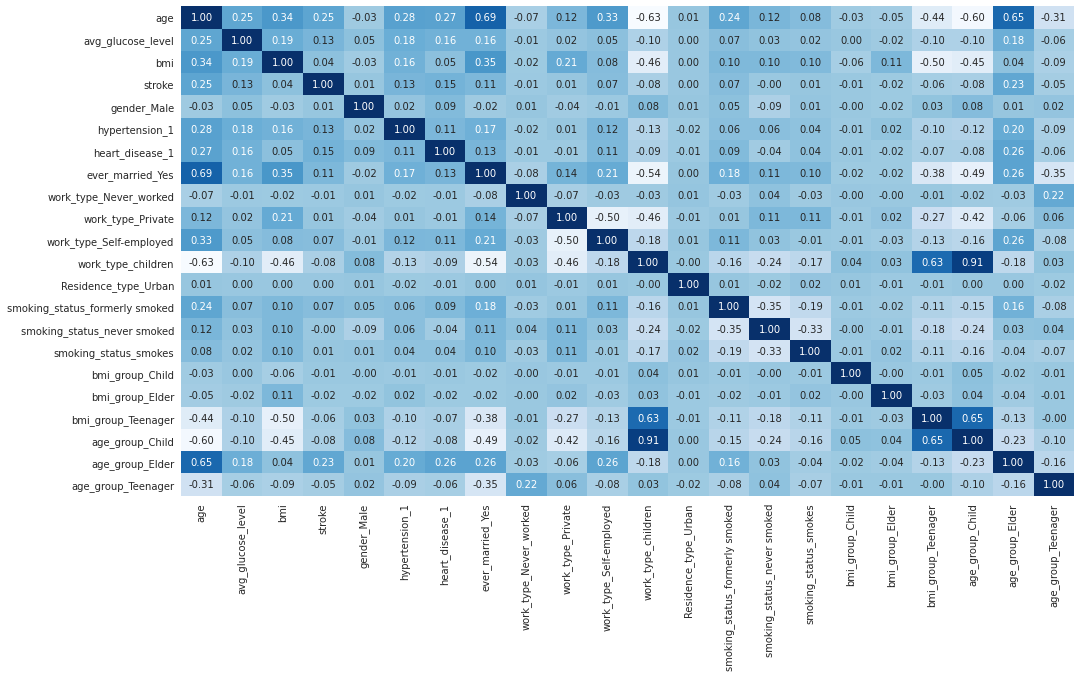

In [24]:
corr = train.corr()
plt.figure(figsize=(16,9))
sns.heatmap(corr, cmap='Blues', cbar=False, annot=True, fmt='.2f')
plt.show()

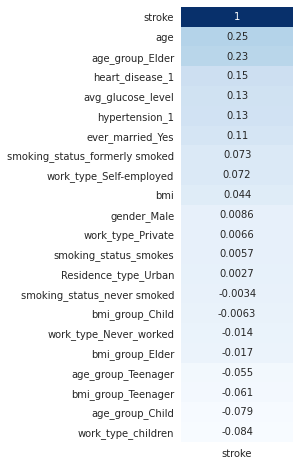

In [25]:
# Correlation with Target

corr = train.corr()[target].sort_values(ascending=False).to_frame()
plt.figure(figsize=(2,8))
sns.heatmap(corr, cmap='Blues', cbar=False, annot=True)
plt.show()

## Preprocessed data

In [26]:
features = ['age', 'avg_glucose_level', 'bmi', 'gender_Male','hypertension_1', 'heart_disease_1', 'ever_married_Yes',
            'work_type_Never_worked', 'work_type_Private','work_type_Self-employed', 'work_type_children', 
            'Residence_type_Urban','smoking_status_formerly smoked', 'smoking_status_never smoked','smoking_status_smokes',
            'bmi_group_Child', 'bmi_group_Elder', 'bmi_group_Teenager', 'age_group_Child', 'age_group_Elder', 'age_group_Teenager']

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train.head()

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,bmi_group_Child,bmi_group_Elder,bmi_group_Teenager,age_group_Child,age_group_Elder,age_group_Teenager
2045,-1.798,-0.436,-1.412,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000
4671,-1.050,-0.590,1.020,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
3539,-1.402,-0.833,-1.386,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000
2002,1.633,-0.351,0.695,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
5086,0.358,1.023,-0.918,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


# Machine Learning
## Decision tree classifier

In [27]:
# Base model
clf = DecisionTreeClassifier(random_state=1)
clf.fit(X_train, y_train)
train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)
print("Train f1 Score :", f1_score(y_train, train_preds))
print("Test f1 Score :", f1_score(y_test, test_preds))

Train f1 Score : 1.0
Test f1 Score : 0.14285714285714285


In [28]:
# Hyperparameter tuning
params = {
    'max_depth': [4, 6, 8, 10, 12, 14, 16, 20],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [5, 10, 20, 30, 40, 50],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128,256],
    'class_weight': [{0: 1, 1: 9}, {0: 1, 1: 4}, {0: 1, 1: 5}, {0: 1, 1: 6}, {0: 1, 1: 7}, {0: 1, 1: 8}]
}

clf = RandomizedSearchCV(DecisionTreeClassifier(random_state=1),
                         params,
                         scoring='f1',
                         verbose=1,
                         random_state=1,
                         cv=5,
                         n_iter=50)

search = clf.fit(X_train, y_train)

print("\nBest f1-score:",search.best_score_)
print("\nBest params:",search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best f1-score: 0.2688928913954958

Best params: {'min_samples_split': 40, 'max_leaf_nodes': 8, 'max_features': 0.8, 'max_depth': 10, 'criterion': 'gini', 'class_weight': {0: 1, 1: 7}}


In [29]:
# Cross validation
clf = DecisionTreeClassifier(random_state = 1, **search.best_params_)
oofs = run_kfold(clf, X_train, y_train, N_SPLITS=5)


------------- Fold 1 -------------

f1 score for validation set is 0.24836601307189543

------------- Fold 2 -------------

f1 score for validation set is 0.21100917431192662

------------- Fold 3 -------------

f1 score for validation set is 0.29714285714285715

------------- Fold 4 -------------

f1 score for validation set is 0.30065359477124187

------------- Fold 5 -------------

f1 score for validation set is 0.287292817679558

Mean validation f1 score : 0.2688928913954958

F1 score for oofs is 0.2659090909090909


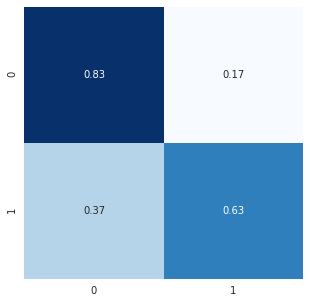

In [30]:
# Final Decision tree classifier
clf = DecisionTreeClassifier(random_state = 1, **search.best_params_)
clf.fit(X_train, y_train)

preds_test = clf.predict_proba(X_test)[:, 1]
    
cm = confusion_matrix(y_test, preds_test.round(), normalize='true')
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False,fmt='.2f')
plt.show()

## Logistic Regression

In [31]:
# Base model
clf = LogisticRegression(random_state=1, class_weight='balanced')
clf.fit(X_train, y_train)
train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)
print("Train f1 Score :", f1_score(y_train, train_preds))
print("Test f1 Score :", f1_score(y_test, test_preds))

Train f1 Score : 0.24349157733537521
Test f1 Score : 0.22377622377622378


In [32]:
# Hyperparameter tuning
params = {
    'penalty': ['l1', 'l2','elasticnet'],
    'C':[0.0001, 0.001, 0.1, 1, 10, 100,1000],
    'fit_intercept':[True, False],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

clf = RandomizedSearchCV(LogisticRegression(random_state=1, class_weight='balanced'),
                         params,
                         scoring='f1',
                         verbose=1,
                         random_state=1,
                         cv=5,
                         n_iter=20)

search = clf.fit(X_train, y_train)

print("\nBest f1-score:",search.best_score_)
print("\nBest params:",search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best f1-score: 0.235615072173141

Best params: {'solver': 'newton-cg', 'penalty': 'l2', 'fit_intercept': True, 'C': 1}


In [33]:
# Cross validation
clf = LogisticRegression(random_state = 1, class_weight='balanced', **search.best_params_)
oofs = run_kfold(clf, X_train, y_train, N_SPLITS=5)


------------- Fold 1 -------------

f1 score for validation set is 0.2274509803921569

------------- Fold 2 -------------

f1 score for validation set is 0.22137404580152675

------------- Fold 3 -------------

f1 score for validation set is 0.2222222222222222

------------- Fold 4 -------------

f1 score for validation set is 0.25702811244979923

------------- Fold 5 -------------

f1 score for validation set is 0.25

Mean validation f1 score : 0.235615072173141

F1 score for oofs is 0.23529411764705885


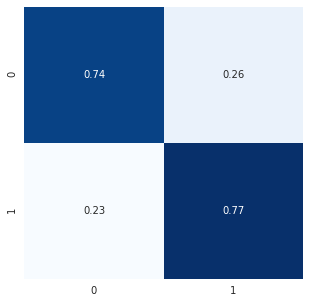

In [34]:
# Final Logistic regression

clf = LogisticRegression(random_state = 1,class_weight='balanced', **search.best_params_)
clf.fit(X_train, y_train)

preds_test = clf.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, preds_test.round(), normalize='true')
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.2f')
plt.show()

## Feature importance or coefficents

In [35]:
imp = pd.DataFrame([features, clf.coef_[0]]).T.sort_values(1, ascending=False).reset_index(drop=True)
imp.columns=['feature', 'coeff']
imp

,feature,coeff
0,work_type_children,2.623
1,age,2.469
2,age_group_Teenager,0.698
3,hypertension_1,0.534
4,heart_disease_1,0.384
5,smoking_status_formerly smoked,0.236
6,smoking_status_smokes,0.216
7,bmi,0.201
8,avg_glucose_level,0.149
9,work_type_Private,0.144


# Save all the transformers
One hot encoder<br>
Standard scaler<br>
Logistic regression<br>
<b> Logistic regression is performing better at predicting the likelihood of Stroke. Which is what we want.!! 

In [36]:
with open("onehotencoder.pkl", 'wb') as f:
    pickle.dump(encoder, f)

with open("scaler.pkl", 'wb') as f:
    pickle.dump(scaler, f)

with open("model.pkl", 'wb') as f:
    pickle.dump(clf, f)

## Replicate the total pipeline for deployment

In [37]:
# Random data point
X = [['Male', 67.0, 0, 1, 'Yes', 'Private', 'Urban', 228.69, 36.6, 'formerly smoked']]
y_true = 1

In [38]:
columns = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type','avg_glucose_level', 'bmi', 'smoking_status']

X = pd.DataFrame(X, columns=columns)
X["age_group"] = X.age.apply(age_group)
X["bmi_group"] = X.age.apply(age_group)

numerical = ['age', 'avg_glucose_level', 'bmi']
categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status','age_group','bmi_group']

# Categorical encoding
cols = encoder.get_feature_names(categorical)
X.loc[:, cols] = encoder.transform(X[categorical])

# Drop categorical features
X.drop(categorical, axis=1, inplace=True)

# Feature scaling
X.loc[:, numerical] = scaler.transform(X[numerical])

print('y_pred :', clf.predict(X)[0])

y_pred : 1


## Thanks for reading!! Please upvote if you like this kernel.